This notebook contains all code needed to re-create Figures 2 and 3 from the paper.  I've also included some additional supplemental analyses and code that are relevant to the main paper.

### Basic setup (import statements, define basic file IO functions, etc.)

In [11]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import scipy.signal as sgn
import pickle
import os
import hypertools as hyp
import future
import ipykernel
from notebook import notebookapp
import json
from pathlib import Path
import urllib
from glob import glob
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.interpolate import pchip
from scipy.signal import find_peaks as localmax
from scipy.stats import ttest_ind as ttest

%matplotlib inline

In [12]:
#annoying hack needed to get the current filename; source: https://stackoverflow.com/questions/12544056/how-do-i-get-the-current-ipython-notebook-name
def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

### Set path, load Sherlock video and recall trajectories

Credit:
1. Organized and pre-processed data (Heusser et al., 2018): [[link](https://github.com/ContextLab/sherlock-topic-model-paper)]
2. Original study data (Chen et al., 2017): [[link](https://dataspace.princeton.edu/jspui/handle/88435/dsp01nz8062179)]

Descriptions (description of methods may be found [here](https://www.biorxiv.org/content/early/2018/09/07/409987)):
- `video_model` contains the scene-by-scene topic trajectories based on human anotations 
- `recall_model` contains the sentence-by-sentence topic vectors for each participant's recalls

In [13]:
rootdir = str(Path(notebook_path()).parent.parent.parent)
datadir = os.path.join(rootdir, 'data')
figdir = os.path.join(rootdir, 'data', 'figs')
if not os.path.exists(figdir):
    os.makedirs(figdir)
video_model, recall_models = np.load(os.path.join(datadir, 'processed', 'models_t100_v50_r10.npy'), allow_pickle=True)

### Some plotting and data wrangling code

In [21]:
# Plot a correlation matrix
def plot_corrmat(c, vmin=0, vmax=1, labels=True, cbar=True, title=''):
    n = c.shape[0]
    ticks = np.linspace(0, n, 5)
    sns.heatmap(c, vmin=vmin, vmax=vmax, cbar=cbar)
    if labels:
        plt.xlabel('Relative time')
        plt.ylabel('Relative time')
        plt.xticks(ticks, np.divide(ticks, n))
        plt.yticks(ticks, np.divide(ticks, n))
    else:
        plt.xticks([], [])
        plt.yticks([], [])
    plt.title(title, fontsize=32)

In [22]:
# Plot a timeseries with error ribbons (95% confidence intervals)
def plot_ribbon(x, color='k', ribbon_alpha=0.2):
    mean = x.mean()
    ci = 1.96 * np.divide(x.std(), np.sqrt(x.shape[0]))
    
    xvals = x.columns
    h = plt.gcf()
    plt.fill_between(xvals, mean - ci, mean + ci, color=color, alpha=ribbon_alpha)
    plt.plot(xvals, mean, color=color)
    
    return h

# Re-sample an array along the given axis or axes
def resample(x, axis=0, nbins=100, interpolate=True):
    if not (type(x) is pd.DataFrame):
        x = pd.DataFrame(x)
    
    if type(axis) is list:
        if len(axis) == 0:
            return x
        else:
            if not(type(nbins) is list):
                nbins = [nbins] * len(axis)
            x = resample(x, axis[0], nbins=nbins[0], interpolate=interpolate)
            for i in np.arange(1, len(axis)):
                x = resample(x, axis[i], nbins=nbins[i], interpolate=interpolate)
            return x
    
    if axis == 1:
        return resample(x.T, axis=0, nbins=nbins, interpolate=interpolate).T
    elif not (axis == 0):
        raise Exception('resampling must be along axis 0 or 1')
    
    if interpolate:
        vals = np.array(x.axes[axis])
        minval = np.min(vals)
        maxval = np.max(vals)

        newvals = np.linspace(minval, maxval, nbins)
        normed_newvals = np.divide(newvals, np.max([np.abs(minval), np.abs(maxval)]))    

        y = np.zeros([nbins, x.shape[1]])
        for i in np.arange(x.shape[1]):
            y[:, i] = pchip(vals, x.iloc[:, i], extrapolate=False)(newvals)

        return pd.DataFrame(y, index=normed_newvals, columns=x.columns)
    else:
        if x.shape[0] > nbins:
            x = x.loc[:nbins, :]
        vals = np.nan * np.ones(nbins)
        n = np.min([x.shape[0], nbins])
        vals[:n] = np.arange(n) / n
        template = np.nan * np.ones([nbins, x.shape[1]])
        template[:n, :] = x.iloc[:n, :]
        return pd.DataFrame(template, index=vals, columns=x.columns)

# Figure 2: temporal correlation matrices of the dynamic content of a television episode and people's recalls of that episode

## Figure 2A

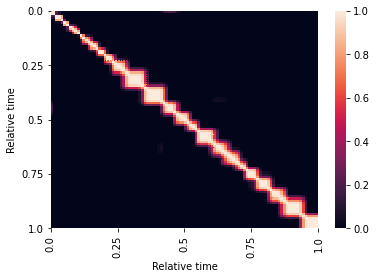

In [90]:
n = 100
video_corrs = resample(pd.DataFrame(video_model).T.corr(), axis=[0, 1], nbins=n)
plot_corrmat(video_corrs)
plt.gcf().savefig(os.path.join(figdir, 'sherlock_video_corrs.pdf'))

## Figure 2B

In [91]:
all_recall_corrs = [resample(pd.DataFrame(r).T.corr(), axis=[0, 1], nbins=n) for r in recall_models]
recall_corrs = np.sum(np.stack(resampled, axis=2), axis=2) / len(recall_models)

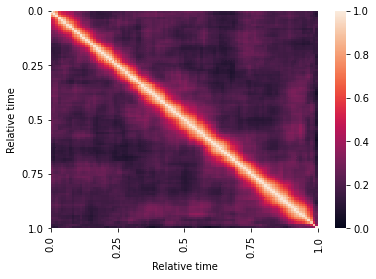

In [92]:
plot_corrmat(recall_corrs)
plt.gcf().savefig(os.path.join(figdir, 'sherlock_recall_corrs.pdf'))

## Figure 2C

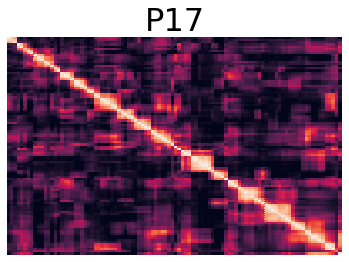

In [93]:
for i, r in enumerate(all_recall_corrs):
    plt.clf()
    plot_corrmat(r, cbar=False, labels=False, title=f'P{i+1}')
    plt.gcf().savefig(os.path.join(figdir, f'sherlock_recall_corrs_P{i}.pdf'))

# Figure 3: Content drift in a television episode and participants' recalls of that episode

## Dynamics time warping

Following [Heusser et al. (2020)](https://www.biorxiv.org/content/10.1101/409987v3), use time warping to project all participant's recalls onto a common timeline.

In [94]:
dtw_files = list(map(lambda x: f's{x}_recall_model_dtw.npy', np.arange(len(recall_models))))
warped_recalls = list(map(lambda f: np.load(os.path.join(datadir, 'processed', f)), dtw_files))

### Data wrangling and plotting functions...

In [95]:
# Vertically align the diagonal entries of a correlation matrix and fill in the remaining entries with nans
# This is used for doing autocorrelation analyses
def parse_diag(M):
    n = M.shape[1]
    x = np.nan * np.zeros([M.shape[0], 2 * n + 1])
    
    for i in np.arange(n):
        x[i, (n - i):n] = M[i, 0:i]
        x[i, n] = M[i, i]
        x[i, (n+1):(n + n - i)] = M[i, (i+1):]
    
    return pd.DataFrame(x, columns=np.arange(-n, n+1))

# Plot the average autocorrelation function for a given correlation matrix
#  - First diagonalize the matrix
#  - Then (optionally) resample it
#  - Then plot a timeseries ribbon
def autocorr_plot(r, color='k', res=False, nbins=101, pass_matrix=False, show_plot=True):
    if pass_matrix:
        M = r
    else:
        M = pd.DataFrame(r).T.corr().values
    x = parse_diag(M).loc[:, 0:]
    x = x.iloc[:, :-1] #get rid of last timepoint (always all nans)

    if res:        
        y = resample(x, axis=1, nbins=nbins)
    else:
        y = x
    if show_plot:
        h = plot_ribbon(y, color=color)
        plt.ylabel('Correlation')
        if res:
            plt.xlabel('Relative time')
        else:
            plt.xlabel('Time (%)')
    
    return y

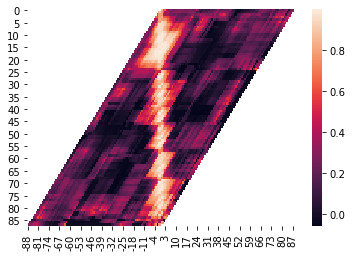

In [96]:
# Create a sample aligned correlation matrix for the example participant (P0)
M = pd.DataFrame(recall_models[0]).T.corr().values
np.fill_diagonal(M, np.nan)
x = parse_diag(M)
h = sns.heatmap(x)

## Figure 3A

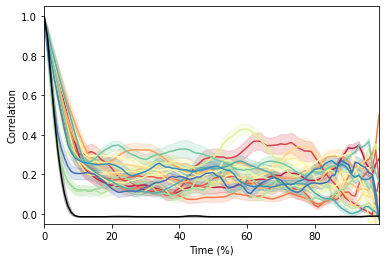

In [97]:
colors = sns.color_palette('Spectral', n_colors=len(recall_models))
for i, r in enumerate(all_recall_corrs):
    autocorr_plot(r.values, color=colors[i], res=False, pass_matrix=True);
autocorr_plot(video_corrs.values, color='k', res=False, pass_matrix=True);
plt.ylim([-0.05, 1.05])
plt.xlim([0, 99])
plt.gcf().savefig(os.path.join(figdir, 'reinstatement_resampled.pdf'))

### Define some stats functions

In [98]:
#Fisher z-transformation
def r2z(r):
    warnings.simplefilter('ignore')
    return 0.5 * (np.log(1 + r) - np.log(1 - r))

#Inverse of Fisher z-transformation
def z2r(z):
    warnings.simplefilter('ignore')
    if isinstance(z, list):
        z = np.array(z)
    r = (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    if isinstance(r, np.ndarray):
        r[np.isinf(z) & (z > 0)] = 1
        r[np.isinf(z) & (z < 0)] = -1
    else:
        if np.isinf(z) & (z > 0):
            return 1
        elif np.isinf(z) & (z < 0):
            return -1
    return r

## Figure 2B

In [99]:
def reinstatement_plot(video, recalls, relative_time, res=False, nbins=101, include_average=True, include_autocorr=True, height=0.1, thresh=None, dist=50):
    if not (type(recalls) is list):
        recalls = [recalls]    
    if res:
        video = resample(video, nbins=nbins).values
        for r in recalls:
            recalls[0] = resample(r, nbins=nbins).values
    ts = np.linspace(0, 1, video.shape[0])
    xlabel = 'Relative time'
    
    if len(recalls) == 1:
        colors = ['k']
    else:
        colors = sns.color_palette('Spectral', n_colors=len(recalls))
    
    x = np.zeros(ts.shape)
    for i, r in enumerate(recalls):
        t = int(np.round(relative_time * (r.shape[0] - 1)))
        next = np.squeeze(1 - cdist(np.atleast_2d(r[t, :]), video, 'correlation'))
        x += r2z(next)
        plt.plot(ts, next, color=colors[i], linewidth=1, alpha=0.4)
    
    y = plt.ylim()
    
    if include_autocorr:
        t = int(np.round(relative_time * video.shape[0] - 1))
        autocorr = np.squeeze(1 - cdist(np.atleast_2d(video[t, :]), video, 'correlation'))                
        lm = localmax(autocorr, height=height, threshold=thresh, distance=dist)[0]
        for m in lm:
            t = ts[m] * video.shape[0]
            p = ts[m]
            print(f'Local video max at t = {t} (prop: {p})')
            #plt.plot([ts[m], ts[m]], [y[0], autocorr[m]], color=[0.5, 0.5, 0.5], linewidth=2)
        plt.plot(ts, autocorr, color=[0.5, 0.5, 0.5], linewidth=2)
    
    if include_average:
        ave = z2r(x / len(recalls))
        plt.plot(ts, ave, color='k', linewidth=2)
        lm = localmax(ave, height=height, threshold=thresh, distance=dist)[0]
        lm_colors = sns.cubehelix_palette(n_colors=len(lm))
        for i, m in enumerate(lm):
            t = ts[m] * video.shape[0]
            p = ts[m]
            print(f'Local recall max at t = {t} (prop: {p})')
            plt.plot(ts[m], ave[m], color=lm_colors[i], marker='o', markeredgecolor='w')
    else:
        lm = []
    
    plt.xlabel(xlabel)
    plt.ylabel('Correlation')
    plt.xlim([np.min(ts), np.max(ts)])
    plt.ylim([-0.05, 1.05])
    
    return lm

Local video max at t = 596.3017721518987 (prop: 0.3017721518987342)
Local video max at t = 651.3296202531646 (prop: 0.329620253164557)
Local recall max at t = 217.10987341772153 (prop: 0.109873417721519)
Local recall max at t = 347.1756962025317 (prop: 0.17569620253164558)
Local recall max at t = 477.2415189873418 (prop: 0.24151898734177216)
Local recall max at t = 570.2886075949368 (prop: 0.2886075949367089)
Local recall max at t = 626.3169620253166 (prop: 0.31696202531645573)
Local recall max at t = 684.3463291139241 (prop: 0.34632911392405064)
Local recall max at t = 751.3802531645571 (prop: 0.38025316455696206)
Local recall max at t = 813.4116455696203 (prop: 0.41164556962025317)
Local recall max at t = 1113.5635443037975 (prop: 0.5635443037974683)
Local recall max at t = 1207.6111392405064 (prop: 0.6111392405063292)
Local recall max at t = 1597.8086075949368 (prop: 0.8086075949367089)


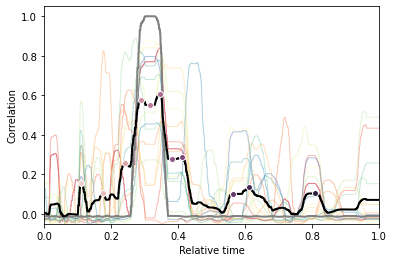

In [100]:
lm = reinstatement_plot(video_model, warped_recalls, 0.328)
plt.gcf().savefig(os.path.join(figdir, 'wave_function.pdf'))

## Key to movie times (from `Sherlock_Segments_1000_NN_2017.xlsx`)

In [103]:
annotations = pd.read_excel(os.path.join(datadir, 'raw', 'Sherlock_Segments_1000_NN_2017.xlsx'))
starts = annotations['Start Time (s) ']
ends = annotations['End Time (s) ']
notes = annotations['Scene Details - A Level ']
starts_TR = annotations['Start Time (TRs, 1.5s)']
ends_TR = annotations['End Time (TRs, 1.5s)']

cutpoint = 482 #movie is divided into two clips, and times (in seconds, not TRs) reset when the second clip starts
correction = ends[cutpoint-1]
starts.iloc[cutpoint:] += correction
ends.iloc[cutpoint:] += correction

In [104]:
def btwn(x, a, b):
    return (x >= a) & (x <= b)

def print_annotation(t):
    def print_time(n, x):
        if n >= cutpoint:
            clip = 2
            c = correction
        else:
            clip = 1
            c = 0
        x -= c
        
        minute = int(np.floor(x / 60))
        second = int(x - (60*minute))
        return f'c{clip}_{minute}m{second}s'
        
        
    i = np.where(btwn(t, starts_TR, ends_TR))[0][0]
    print(f'Time: {print_time(i, starts.iloc[i])}--{print_time(i, ends.iloc[i])} (TR: {int(starts_TR.iloc[i])}--{int(ends_TR.iloc[i])}); Description: {notes.iloc[i]}\n')

In [105]:
for m in lm:
    print_annotation(m)

Time: c1_5m22s--c1_5m28s (TR: 216--219); Description: Beth is seen outside in the dark at night having slipped out of the venue. She is next to her car looking for her keys in her bag. She sighs when she can't find them and looks around helplessly. 

Time: c1_8m39s--c1_8m40s (TR: 347--347); Description: John uncomfortably says: "Yeah, I'm not the John Watson…" and never finishes his sentence.

Time: c1_11m53s--c1_11m57s (TR: 476--478); Description: John turns back to Sherlock and says: "We don't know a thing about each other; I don't know where we're meeting; I don't even know your name."

Time: c1_14m13s--c1_14m17s (TR: 570--571); Description: Sherlock trots up the stairs to the first floor landing, then pauses and waits for John.

Time: c1_15m37s--c1_15m41s (TR: 626--627); Description: John looks up at Sherlock and explains: "You said you could identify a software designer by his tie and an airplane pilot by his left thumb."

Time: c1_17m5s--c1_17m7s (TR: 684--685); Description: Mrs.

### Human description of local maxima (used in Fig. 3C):
- *Time 5:22 (clip 1) -- 5:28*: victim dying
- *Time 8:39 -- 8:40*: Watson meets with old friend who suggests moving in with a roomate
- *Time 11:53 -- 11:57*: Sherlock and Watson are introduced, Sherlock makes a series of deductions about Watson
- *Time 14:13 -- 14:17*: Sherlock shows Watson his apartment at 221b Baker Street, where they will be living
- *Time 15:37 -- 15:41*: Sherlock and Watson bantering in their apartment, then interrupted by detective who reports new victim [**reference event tagged for recall**]
- *Time 17:05 -- 17:07*: Watson settling into apartment (interaction with land lady)
- *Time 18:42 -- 18:49*: Sherlock smuggly deducing things while Watson looks on with obvious curiosity
- *Time 20:15 -- 20:23*: Flashback to when Sherlock was making deductions about Watson
- *Time 4:09 (clip 2) -- 4:11*: Sherlock making deductions about dead body
- *Time 6:30 -- 6:31*: Sherlock making deductions about dead body
- *Time 16:13 -- 16:18*: Mysterious man warns Watson away from Sherlock